In [1]:
import dqc
import torch
import xitorch.optimize
import time

In [2]:
dtype = torch.float64
dev = torch.tensor([0.0], dtype=dtype).requires_grad_()
basis_321g = dqc.loadbasis("7:pc-1")

def fcn(dist, dev):
    atompos = torch.tensor([[-0.5, 0, 0], [0.5, 0, 0]], dtype=dtype) * dist
    atomzs = torch.cat((7. + dev, 7. - dev), dim=0)
    m = dqc.Mol((atomzs, atompos), basis=[basis_321g, basis_321g], spin=0)
    ene = dqc.HF(m).run().energy()
    return ene


In [3]:
t0 = time.time()
print("Finding the equilibrium position")
dist = torch.tensor(2.05, dtype=dtype).requires_grad_()
equil_atompos = xitorch.optimize.minimize(fcn, dist, (dev,), method="gd",
                                          step=1e-1, maxiter=200, f_rtol=1e-10,
                                          verbose=True)
equil_ene_n2 = fcn(equil_atompos, dev)
print(time.time() - t0)

Finding the equilibrium position
   #:             f |        dx,        df
   1: -1.089148e+02 | 4.351e-03, 1.089e+02
  10: -1.089153e+02 | 6.209e-03, 9.777e-05
  20: -1.089153e+02 | 6.897e-04, 2.821e-05
  30: -1.089153e+02 | 2.091e-03, 1.245e-05
  40: -1.089153e+02 | 4.467e-04, 3.370e-06
  50: -1.089153e+02 | 6.845e-04, 1.435e-06
Finish with convergence
  59: -1.089153e+02 | 3.957e-04, 4.859e-09
28.606213569641113


In [4]:
# gradient of the equilibrium position w.r.t. dev
t0 = time.time()
gposdev, = torch.autograd.grad(equil_atompos, dev, create_graph=True)
gposdev2, = torch.autograd.grad(gposdev, dev, create_graph=True)
t1 = time.time()
print(gposdev, gposdev2, t1 - t0)
genedev, = torch.autograd.grad(equil_ene_n2, dev, create_graph=True)
genedev2, = torch.autograd.grad(genedev, dev, create_graph=True)
t2 = time.time()
print(genedev, genedev2, t2 - t1)

tensor([-2.8929e-11], dtype=torch.float64, grad_fn=<AddBackward0>) tensor([0.1326], dtype=torch.float64, grad_fn=<AddBackward0>) 12.780527114868164
tensor([7.6158e-12], dtype=torch.float64, grad_fn=<AddBackward0>) tensor([-3.9603], dtype=torch.float64, grad_fn=<AddBackward0>) 14.195071697235107


In [5]:
devs = torch.linspace(-2.0, 2.0, 41, dtype=dtype)
dist0 = torch.tensor(2.0, dtype=dtype)
equil_dists = []
equil_enes = []
for i, dev2 in enumerate(devs):
    print(i, dev2)
    equil_dist = xitorch.optimize.minimize(fcn, dist0, (dev2.unsqueeze(0),), method="gd",
                                           step=1e-2, maxiter=2000, f_rtol=1e-10,
                                           verbose=True)
    dist0 = equil_dist.detach()
    equil_dists.append(equil_dist.detach())
    equil_enes.append(fcn(equil_dist, dev2.unsqueeze(0)).detach())

0 tensor(-2., dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.173564e+02 | 5.655e-03, 1.174e+02
  10: -1.174142e+02 | 2.288e-02, 4.616e-03
  20: -1.174207e+02 | 7.373e-03, 5.822e-04
  30: -1.174193e+02 | 3.258e-03, 2.352e-04
  40: -1.174222e+02 | 4.924e-03, 2.055e-04
  50: -1.174227e+02 | 2.003e-03, 2.179e-05
  60: -1.174226e+02 | 5.911e-04, 8.891e-06
  70: -1.174227e+02 | 1.017e-03, 8.315e-06
  80: -1.174228e+02 | 3.584e-04, 1.128e-06
  90: -1.174228e+02 | 1.502e-04, 5.096e-07
 100: -1.174228e+02 | 2.112e-04, 3.299e-07
Finish with convergence
 106: -1.174228e+02 | 1.302e-04, 3.818e-10
1 tensor(-1.9000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.165380e+02 | 2.678e-04, 1.165e+02
  10: -1.165382e+02 | 1.376e-03, 2.230e-05
  20: -1.165383e+02 | 7.737e-04, 2.464e-07
  30: -1.165383e+02 | 6.228e-05, 1.294e-08
  40: -1.165383e+02 | 3.027e-04, 9.449e-07
  50: -1.165383e+02 | 1.398e-04, 7.014e-08
Finish with convergence
  58: -1.165383e+0

  20: -1.089946e+02 | 4.445e-05, 5.675e-08
Finish with convergence
  24: -1.089946e+02 | 1.042e-05, 1.789e-09
23 tensor(0.3000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.090938e+02 | 5.503e-05, 1.091e+02
  10: -1.090938e+02 | 2.473e-04, 6.080e-07
  20: -1.090938e+02 | 6.274e-05, 1.079e-07
Finish with convergence
  24: -1.090938e+02 | 1.295e-05, 5.740e-09
24 tensor(0.4000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.092329e+02 | 7.668e-05, 1.092e+02
  10: -1.092329e+02 | 3.455e-04, 1.192e-06
  20: -1.092329e+02 | 9.026e-05, 2.100e-07
  30: -1.092329e+02 | 9.648e-05, 1.479e-07
Finish with convergence
  38: -1.092329e+02 | 7.465e-05, 1.046e-08
25 tensor(0.5000, dtype=torch.float64)
   #:             f |        dx,        df
   1: -1.094123e+02 | 1.191e-04, 1.094e+02
  10: -1.094123e+02 | 5.379e-04, 2.900e-06
  20: -1.094123e+02 | 1.451e-04, 5.056e-07
  30: -1.094123e+02 | 1.473e-04, 3.517e-07
Finish with convergence
  39: -1.0941

In [6]:
import matplotlib.pyplot as plt

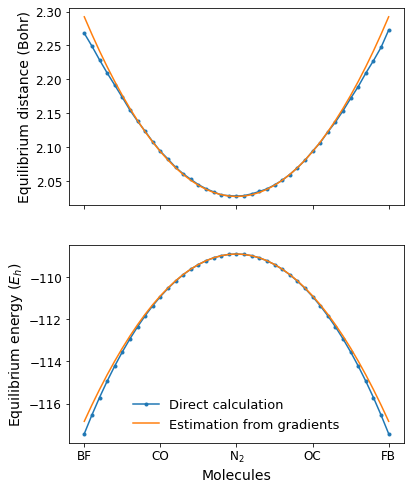

In [12]:
tick_fontsize = 12
label_fontsize = 14
legend_fontsize = 13
plt.figure(figsize=(6, 8))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    if i == 0:
        estimated_poss = equil_atompos.detach() + gposdev.detach() * devs + gposdev2.detach() * devs * devs / 2
        plt.plot(devs, equil_dists, '.-', label="Direct calculation")
        plt.plot(devs, estimated_poss,
                 label="Estimation from gradients")
    else:
        estimated_enes = equil_ene_n2.detach() + genedev.detach() * devs + genedev2.detach() * devs * devs / 2
        plt.plot(devs, equil_enes, '.-', label="Direct calculation")
        plt.plot(devs, estimated_enes,
                 label=r"Estimation from gradients")
    plt.yticks(fontsize=tick_fontsize)
    if i == 0:
        plt.xticks([-2, -1, 0, 1, 2], ["BF", "CO", "N$_2$", "OC", "FB"], fontsize=tick_fontsize, color="white")
    else:
        plt.xticks([-2, -1, 0, 1, 2], ["BF", "CO", "N$_2$", "OC", "FB"], fontsize=tick_fontsize)
        plt.xlabel("Molecules", fontsize=label_fontsize)
    if i == 0:
        plt.ylabel("Equilibrium distance (Bohr)", fontsize=label_fontsize)
    else:
        plt.ylabel("Equilibrium energy ($E_h$)", fontsize=label_fontsize)
        plt.legend(fontsize=legend_fontsize, frameon=False)

In [8]:
print(estimated_poss[0] - equil_dists[0])
print(estimated_poss[10] - equil_dists[10])

tensor(0.0244, dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)


In [9]:
print(estimated_enes[0] - equil_enes[0])
print(estimated_enes[10] - equil_enes[10])

tensor(0.5869, dtype=torch.float64)
tensor(0.0330, dtype=torch.float64)


In [10]:
print(estimated_poss[0])
print(estimated_poss[10])

tensor(2.2922, dtype=torch.float64)
tensor(2.0932, dtype=torch.float64)


In [11]:
print(equil_dists[0])
print(equil_dists[10])

tensor(2.2678, dtype=torch.float64)
tensor(2.0937, dtype=torch.float64)
